In [1]:
from map_tool_box.modules import Neural_Network
from map_tool_box.modules import Data_Transformation
from map_tool_box.modules import Data_Structure
from map_tool_box.modules import Data_Map
from matplotlib import colors as mcolors
from map_tool_box.modules import Utils
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from torch import nn
import numpy as np
import torch

# make neural network for monocular depth estimation, need 4gb VRAM
## inputs RGB image and outputs 2D depth map

In [2]:
Conv2d = nn.Conv2d
Norm = nn.BatchNorm2d
ConvTranspose2d = nn.ConvTranspose2d
in_channels_key = 'in_channels'
out_channels_key = 'out_channels'

# make scalable network structures
# DGNLNet https://ieeexplore.ieee.org/abstract/document/9318521
num_groups = 32
def rescale(base, scale):
    return max(1, int(base*scale))
scale = 1 # scales number of channels in each layer
n_input_channels = 3
device = 'cuda:1'
model_func = Neural_Network.cnn # custom method for creating a CNN
model_params = {
    'block_layers':[
        [
            [Conv2d, {in_channels_key:n_input_channels, out_channels_key:rescale(32, scale), 'kernel_size':4, 'stride':2, 'padding':1}],
            [Norm, {'num_features':rescale(32, scale)}],
            [nn.SELU],
        ],
        [
            [Conv2d, {in_channels_key:rescale(32, scale), out_channels_key:rescale(64, scale), 'kernel_size':4, 'stride':2, 'padding':1}],
            [Norm, {'num_features':rescale(64, scale)}],
            [nn.SELU],
        ],
        [
            [Conv2d, {in_channels_key:rescale(64, scale), out_channels_key:rescale(128, scale), 'kernel_size':4, 'stride':2, 'padding':1}],
            [Norm, {'num_features':rescale(128, scale)}],
            [nn.SELU],
        ],
        [
            [Conv2d, {in_channels_key:rescale(128, scale), out_channels_key:rescale(256, scale), 'kernel_size':4, 'stride':2, 'padding':1}],
            [Norm, {'num_features':rescale(256, scale)}],
            [nn.SELU],
        ],
        [
            [Conv2d, {in_channels_key:rescale(256, scale), out_channels_key:rescale(256, scale), 'kernel_size':3, 'dilation':2, 'padding':2}],
            [Norm, {'num_features':rescale(256, scale)}],
            [nn.SELU],
        ],
        [
            [Conv2d, {in_channels_key:rescale(256, scale), out_channels_key:rescale(256, scale), 'kernel_size':3, 'dilation':4, 'padding':4}],
            [Norm, {'num_features':rescale(256, scale)}],
            [nn.SELU],
        ],
        [
            [Conv2d, {in_channels_key:rescale(256, scale), out_channels_key:rescale(256, scale), 'kernel_size':3, 'dilation':2, 'padding':2}],
            [Norm, {'num_features':rescale(256, scale)}],
            [nn.SELU],
        ],
        [
            [ConvTranspose2d, {in_channels_key:rescale(256, scale), out_channels_key:rescale(128, scale), 'kernel_size':4, 'stride':2, 'padding':1}],
            [Norm, {'num_features':rescale(128, scale)}],
            [nn.SELU],
        ],
        [
            [ConvTranspose2d, {in_channels_key:rescale(128, scale), out_channels_key:rescale(64, scale), 'kernel_size':4, 'stride':2, 'padding':1}],
            [Norm, {'num_features':rescale(64, scale)}],
            [nn.SELU],
        ],
        [
            [ConvTranspose2d, {in_channels_key:rescale(64, scale), out_channels_key:rescale(32, scale), 'kernel_size':4, 'stride':2, 'padding':1}],
            [Norm, {'num_features':rescale(32, scale)}],
            [nn.SELU],
        ],
        [
            [ConvTranspose2d, {in_channels_key:rescale(32, scale), out_channels_key:rescale(32, scale), 'kernel_size':4, 'stride':2, 'padding':1}],
            [Norm, {'num_features':rescale(32, scale)}],
            [nn.SELU],
        ],
        [
            [Conv2d, {in_channels_key:rescale(32, scale), out_channels_key:rescale(32, scale), 'kernel_size':3, 'padding':1}],
            [nn.SELU],
            [Conv2d, {in_channels_key:rescale(32, scale), out_channels_key:1, 'kernel_size':1, 'stride':1, 'padding':0}],
            [nn.Sigmoid],
        ],
    ]
}
model = model_func(**model_params).to(device)
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

# fetch data RGB image and target 2D depth map

In [3]:
# use data tool and set map to fetch data from -- we will use the AirSimNH map
    # memory_saver=True only caches recent data when loading from file -- it is slower but takes significantly less RAM
data_map = Data_Map.DataMapRoof('AirSimNH', memory_saver=True)

# set sensor names from precollected data using tool
rgb_sensor_name = 'SceneV1'
depth_sensor_name = 'DepthV1'

## get one data point at given coords

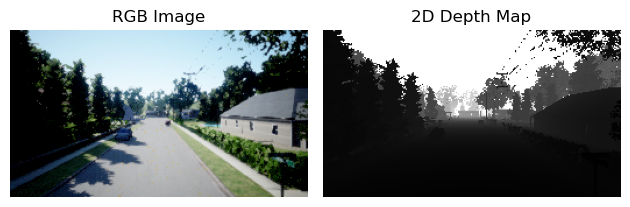

In [4]:
# we will fetch one data point from the given coordinates
x, y, z, direction = 0, 0, 4, 0
point = Data_Structure.Point(x, y, z, direction)

# fetch data
rgb_image = data_map.get_data_point(point, rgb_sensor_name)
depth_map = data_map.get_data_point(point, depth_sensor_name)

# visualize data
fig, axs = plt.subplots(ncols=2)

ax = axs[0]
ax.imshow(Data_Transformation.channel_first_to_last(rgb_image))
ax.set_title('RGB Image')
ax.axis('off')

ax = axs[1]
ax.set_title('2D Depth Map')
ax.imshow(depth_map[0], cmap='grey')
ax.axis('off')

fig.tight_layout()
plt.show()

## check dimensions of neural network

In [5]:
# feed feature vector forward block by block
x = torch.tensor(np.array([rgb_image.astype(np.float32)])).to(device)
print(f'Input shape: {x.shape[1:]}')
for block in model.children():
    x = block(x)
    print(f'Output shape after {block}: {x.shape[1:]}')

Input shape: torch.Size([3, 144, 256])
Output shape after Sequential(
  (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SELU()
): torch.Size([32, 72, 128])
Output shape after Sequential(
  (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SELU()
): torch.Size([64, 36, 64])
Output shape after Sequential(
  (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SELU()
): torch.Size([128, 18, 32])
Output shape after Sequential(
  (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SELU()
): torch.Size([256, 9, 16])
Output shape after Sequ

# sample training, validation, and testing data

In [6]:
# randomly grabs valid data points from map
sample_size = 1000
sampled_points, fetched_data = data_map.sample_data(
    sensor_names=[rgb_sensor_name, depth_sensor_name],
    sample_size=sample_size,
)

# unpack data into train, val, test sets

n_train = int(0.8*(sample_size))
n_val = int(0.1*(sample_size))
n_test = int(0.1*(sample_size))

points_train = sampled_points[:n_train]
X_train = fetched_data[rgb_sensor_name][:n_train]
Y_train = fetched_data[depth_sensor_name][:n_train]

points_val = sampled_points[n_train:n_train+n_val]
X_val = fetched_data[rgb_sensor_name][n_train:n_train+n_val]
Y_val = fetched_data[depth_sensor_name][n_train:n_train+n_val]

points_test = sampled_points[n_train+n_val:n_train+n_val+n_test]
X_test = fetched_data[rgb_sensor_name][n_train+n_val:n_train+n_val+n_test]
Y_test = fetched_data[depth_sensor_name][n_train+n_val:n_train+n_val+n_test]

print('training data shape:', X_train.shape, Y_train.shape)
print('validation data shape:', X_val.shape, Y_val.shape)
print('testing data shape:', X_test.shape, Y_test.shape)

training data shape: (800, 3, 144, 256) (800, 1, 144, 256)
validation data shape: (100, 3, 144, 256) (100, 1, 144, 256)
testing data shape: (100, 3, 144, 256) (100, 1, 144, 256)


# train network

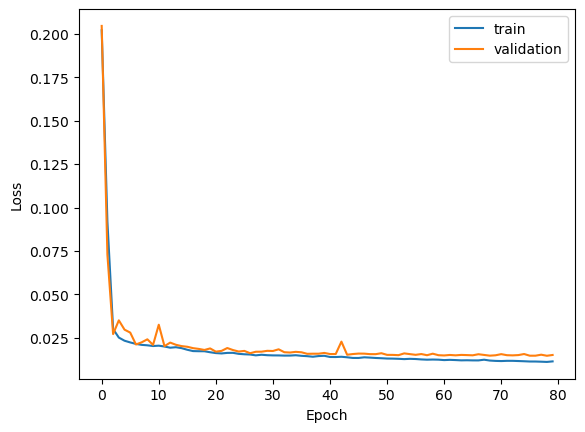

In [7]:
# misc params
batch_size = 32
device = 'cuda:0'

# make pytorch dataloaders
dataloaders = {
    'train':Neural_Network.make_dataloader(X=X_train, Y=Y_train, batch_size=batch_size, shuffle=True, drop_last=True),
    'validation':Neural_Network.make_dataloader(X=X_val, Y=Y_val, batch_size=batch_size),
}

# set optimizer
optimizier_func = torch.optim.Adam
optimizer_params = {}

# set learning rate scheduler
lr_scheduler_func = torch.optim.lr_scheduler.StepLR
lr_scheduler_params = {'step_size':30}

# preprocessing to do on each mini-batch after loading data
x_preproc_funcs = [Neural_Network.preprocess_RGB]
x_preproc_paramss = [{}]
y_preproc_funcs = [Neural_Network.preprocess_grey]
y_preproc_paramss = [{}]
y_postproc_funcs = [Neural_Network.postprocess_grey]
y_postproc_paramss = [{}]

# call training loop
model, train_losses, eval_losses, train_times = Neural_Network.train(model_func, model_params, 
    optimizier_func, optimizer_params, dataloaders, 
    device=device, evaluate_each_epoch=True, show_curve_freq=1,
    lr_scheduler_func=lr_scheduler_func, lr_scheduler_params=lr_scheduler_params,
    train_x_preproc_funcs=x_preproc_funcs, train_x_preproc_paramss=x_preproc_paramss, 
    train_y_preproc_funcs=y_preproc_funcs, train_y_preproc_paramss=y_preproc_paramss,
    eval_x_preproc_funcs=x_preproc_funcs, eval_x_preproc_paramss=x_preproc_paramss, 
    eval_y_preproc_funcs=y_preproc_funcs, eval_y_preproc_paramss=y_preproc_paramss,
 )

# evaluate model on test data

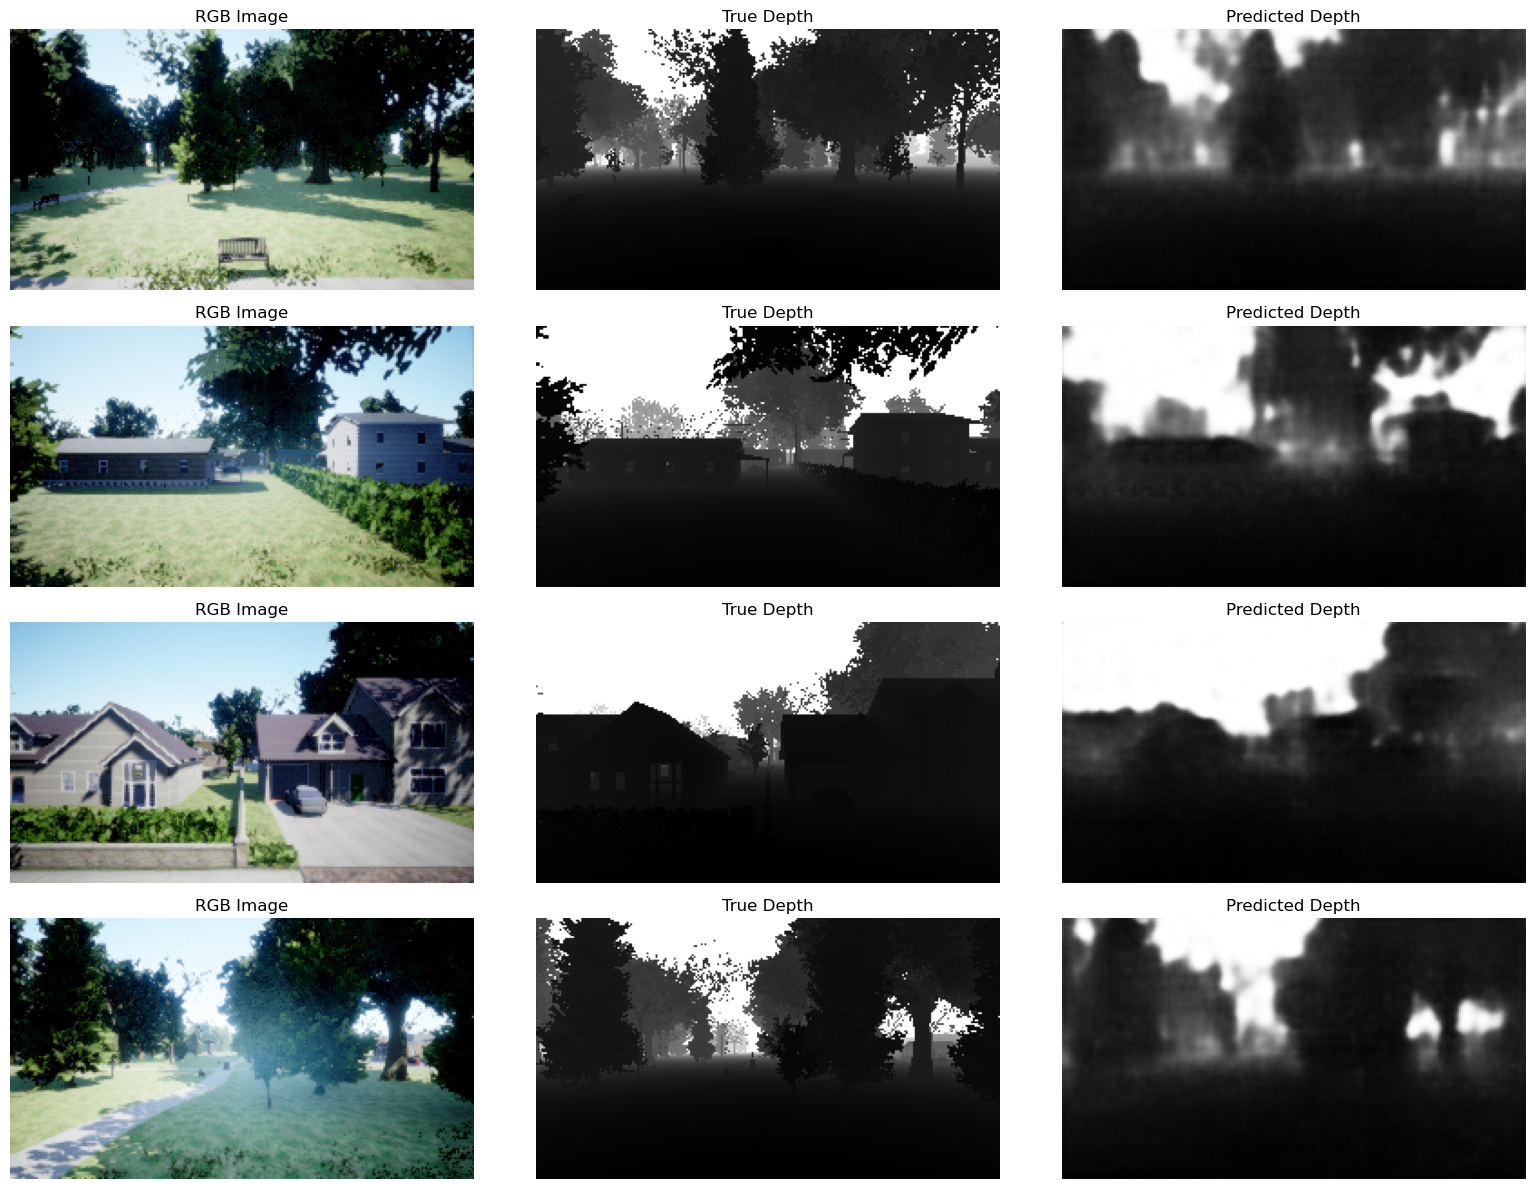

total r2 score = 0.8595005082269336


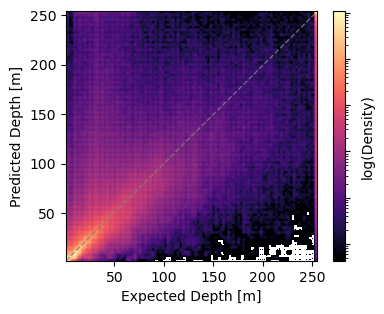

In [8]:
# make pytorch dataloader for test data
test_dataloader = Neural_Network.make_dataloader(X=X_test, Y=Y_test, batch_size=batch_size)


# get predictions on test data
predictions = Neural_Network.get_predictions(model, test_dataloader, device=device, 
                                      x_preproc_funcs=x_preproc_funcs, x_preproc_paramss=x_preproc_paramss,
                                      y_postproc_funcs=y_postproc_funcs, y_postproc_paramss=y_postproc_paramss)


# compare first 4 predictions
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(16,12))
for i in range(4):
    
    ax = axs[i, 0]
    rgb = X_test[i]
    ax.imshow(Data_Transformation.channel_first_to_last(rgb))
    ax.set_title('RGB Image')
    ax.axis('off')

    ax = axs[i, 1]
    truth = Y_test[i]
    ax.set_title('True Depth')
    ax.imshow(truth[0], cmap='grey')
    ax.axis('off')

    ax = axs[i, 2]
    predicted = predictions[i]
    ax.set_title('Predicted Depth')
    ax.imshow(predicted[0], cmap='grey')
    ax.axis('off')

fig.tight_layout()
plt.show()


# calculate r2
r2 = r2_score(Y_test.flatten().astype(np.float32), predictions.flatten().astype(np.float32))
print('total r2 score =', r2)


# r2 plot
hist, x_edges, y_edges = np.histogram2d(Y_test.flatten(), predictions.flatten(), bins=100, density=True)
fig, ax = plt.subplots(figsize=(4,4))
ax.plot([x for x in x_edges], [y for y in y_edges], color='grey', linestyle='--', linewidth=1, alpha=0.8)
im = ax.imshow(hist.T, origin='lower', norm=mcolors.LogNorm(),#vmin=0, vmax=1, clip=True),
               extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap='magma', aspect='equal')
ax.set_xlabel('Expected Depth [m]')
ax.set_ylabel('Predicted Depth [m]')
cbar = plt.colorbar(im, label='log(Density)', shrink=0.7)
cbar.ax.set_xticklabels([])
cbar.ax.set_yticklabels([])

fig.tight_layout()
plt.show()